In [1]:
import os
import glob
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
path = os.getcwd()
all_files = glob.glob(os.path.join(path, '*.csv'))
all_files.sort()

## Some data preparation as combining all the csv files for a even a quarter and reading them in a DataFrame would overload the memory

We parse every csv file separately and extract the relevant informations we want in order to start : the number of each hard drive model, the number of failures of each model and the running time before failure.

In [3]:
index = ['Hitachi HDS5C3030ALA630', 'Hitachi HDS5C4040ALE630',
       'ST4000DM000', 'HGST HMS5C4040BLE640', 'WDC WD30EFRX',
       'ST8000DM002', 'WDC WD5000LPVX', 'HGST HMS5C4040ALE640',
       'Hitachi HDS723030ALA640', 'TOSHIBA MD04ABA400V', 'ST6000DX000',
       'TOSHIBA DT01ACA300', 'WDC WD60EFRX', 'ST4000DX000',
       'HGST HUH728080ALE600', 'ST500LM012 HN', 'ST8000NM0055',
       'TOSHIBA MD04ABA500V', 'WDC WD1600AAJS', 'ST9320325AS',
       'WDC WD40EFRX', 'HGST HDS5C4040ALE630', 'HGST HDS724040ALE640',
       'Hitachi HDS5C3030BLE630', 'ST9250315AS',
       'Hitachi HDS724040ALE640', 'TOSHIBA MQ01ABF050', 'ST31500541AS',
       'ST3160318AS', 'WDC WD5000LPCX', 'WDC WD20EFRX', 'ST3160316AS',
       'WDC WD3200BEKX', 'Hitachi HDS723030BLE640', 'WDC WD2500BPVT',
       'WDC WD5000BPKT', 'ST250LM004 HN', 'ST320LT007',
       'Hitachi HDT725025VLA380', 'ST4000DX002', 'WDC WD3200AAJS',
       'ST6000DM001', 'WDC WD2500AAJS', 'WDC WD3200LPVX',
       'WDC WD2500BEVT', 'WDC WD5003ABYX', 'WDC WD5002ABYS',
       'Hitachi HDS722020ALA330', 'ST1000LM024 HN', 'ST33000651AS',
       'WDC WD1600BPVT', 'ST3500320AS', 'WDC WD10EADS', 'WDC WD10EACS',
       'WDC WD10EADX', 'WDC WD1000FYPS']
df = pd.DataFrame(index=index)
failures = pd.DataFrame(index=index)
models_fail_times = pd.DataFrame(columns=['model', 'smart_9_raw'])

for file in all_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    temp = pd.read_csv(file)
    df[filename] = temp.groupby('model').size()
    failures[filename] = temp.groupby('model')['failure'].agg(sum)
    X = temp[temp['failure'] == 1][['model', 'smart_9_raw']]
    models_fail_times = pd.concat([models_fail_times, X])
df['drives_days'] = df.sum(axis=1)
failures['total'] = failures.sum(axis=1)
models_fail_times['smart_9_raw'] = pd.to_numeric(models_fail_times['smart_9_raw'])

We compute the annualized failure rates by mobdel. This can be greater than 100 (in the case that hard drives don't last more than a year).

In [4]:
failure_rates = failures['total'] / df['drives_days'] * 365 * 100

# Plots of annualized failure rates by model
This first plot is not very readable but at least we can see that in 2017, a lot of ST350032AS died. This tell us a little because those disk could have been there for a long time.

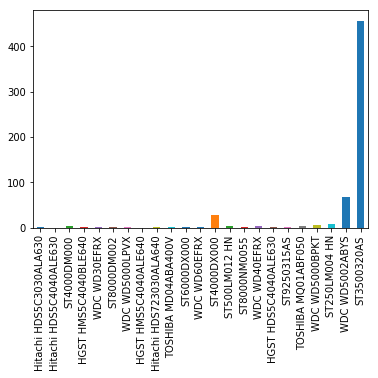

In [5]:
failure_rates[failure_rates > 0].plot(kind="bar")

Removing certain models, we obtain a more readable plot.

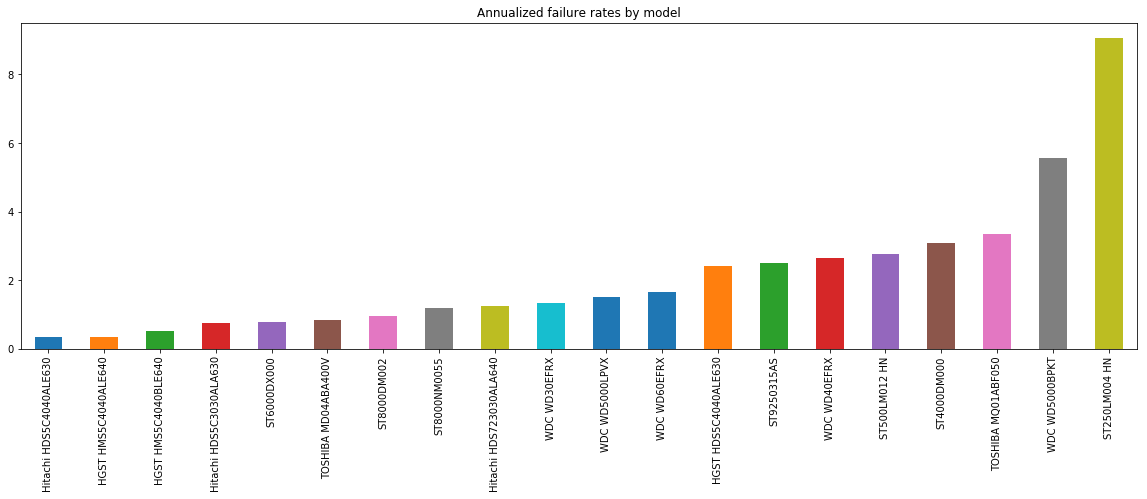

In [6]:
failure_rates[(0 < failure_rates)  & (failure_rates < 10)].sort_values().plot(kind="bar", figsize=(20,6), title='Annualized failure rates by model')

Those plots give us a first idea of what happens with certain hard drives. But we have to go a little further as the expected lifetime of a hard drive is certainly more than a year. We will thus explore more data from 2013 until now in future work.

In [7]:
nb_hard_drives = df['2017-01-01']

# Proportions of models in the hard drives park

Now let's look at the proportions of disk models.

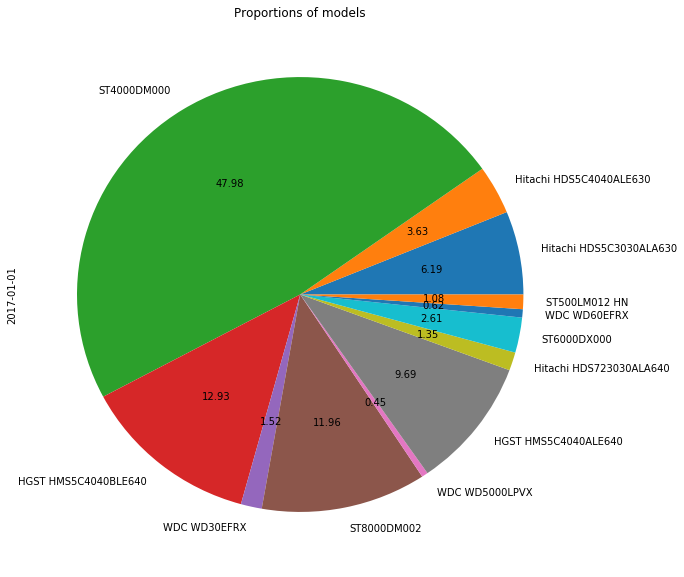

In [8]:
nb_hard_drives[nb_hard_drives > 250].plot.pie(figsize=(10,10), title='Proportions of models', autopct='%.2f')

One could ask why there seems to be a lot of ST4000DM000 even if is not, apparently, the most reliable hard drive out there.

A first approach to answer this question would be to remark that 1 year of analysis is not enough because the expected lifetime of a hardrive is supposedly greater than a year.

One could also take a look at the expected lifetime of each model. We can have this information by looking at SMART 9 which gives the running time of each hard drive. 

Considering every disk that failed in 2017, let's look at their last running time.

# Running times (in days) before failure by models

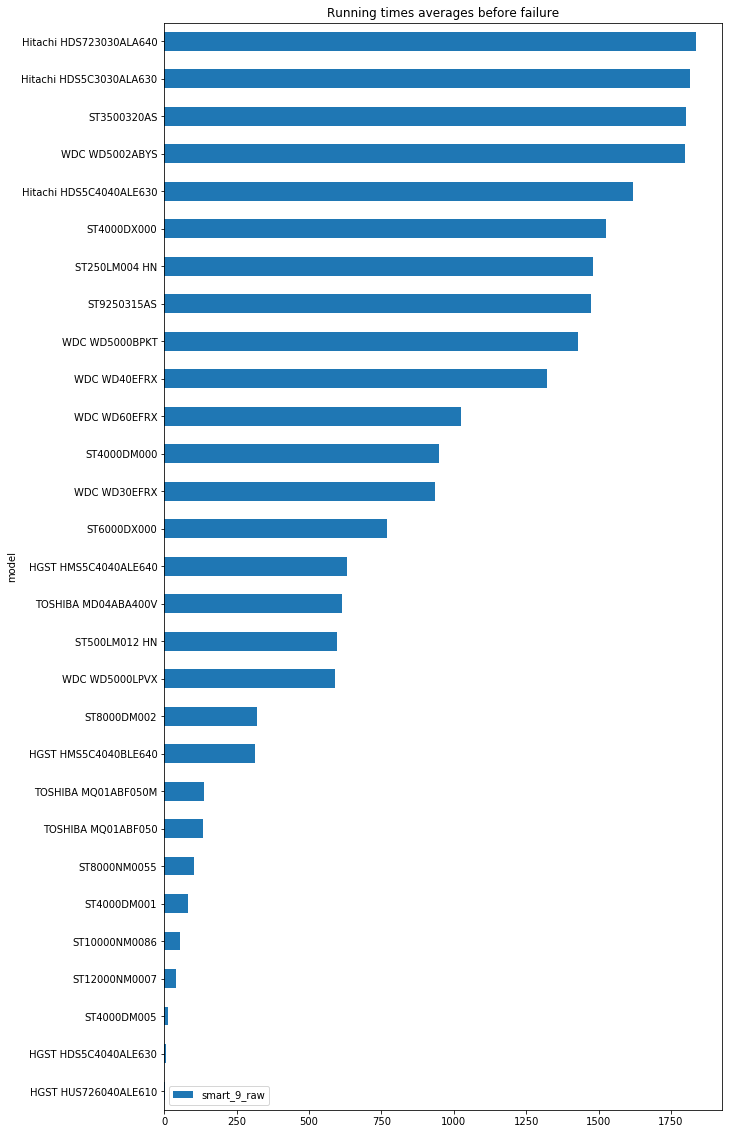

In [11]:
(models_fail_times.groupby('model').agg(np.mean).sort_values(by='smart_9_raw') / 24).plot(kind='barh', figsize=(10,20), title='Running times averages before failure')

Again, the ST4000DM000 model is not the one which was running for the longest time (in average), but again, more data is needed in order to have more precise informations.

Moreover, we didn't look at still running hard drive and their current running times, nor their proporitions.

This will also be explored in future work.